In [1]:
import json
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def clean_prediction(prediction):
    if not isinstance(prediction, str):
        return None
    match = re.match(r"^\s*([A-D])", prediction)
    if match:
        return match.group(1)
    return None

def load_predictions(filename):
    with open(filename, 'r') as f:
        return json.load(f)

def load_ground_truth(test_dir):
    ground_truth = {}
    for subdir in os.listdir(test_dir):
        data_path = os.path.join(test_dir, subdir, 'data.json')
        if os.path.exists(data_path):
            with open(data_path, 'r') as f:
                data = json.load(f)
                ground_truth[subdir] = {
                    'answer': data.get('answer'),
                    'problem_type_graph': data.get('problem_type_graph', []),
                    'problem_type_goal': data.get('problem_type_goal', [])
                }
    return ground_truth

def analyze_accuracies(predictions, ground_truth):
    results = []
    for pred in predictions:
        problem_id = pred['problem_id']
        if problem_id in ground_truth:
            gt = ground_truth[problem_id]
            cleaned_pred = clean_prediction(pred['prediction'])
            is_correct = cleaned_pred == gt['answer']
            results.append({
                'problem_id': problem_id,
                'prediction': cleaned_pred,
                'ground_truth': gt['answer'],
                'is_correct': is_correct,
                'problem_type_graph': gt['problem_type_graph'],
                'problem_type_goal': gt['problem_type_goal']
            })
    return results

In [9]:
direct_pred_path = 'predictions_direct.json'
thinking_pred_path = 'predictions_thinking.json'

dataset_path = '../test'

In [10]:
direct_preds = load_predictions(direct_pred_path)
thinking_preds = load_predictions(thinking_pred_path)
ground_truth = load_ground_truth(dataset_path)

In [11]:
direct_results = analyze_accuracies(direct_preds, ground_truth)
thinking_results = analyze_accuracies(thinking_preds, ground_truth)

direct_df = pd.DataFrame(direct_results)
thinking_df = pd.DataFrame(thinking_results)

direct_accuracy = direct_df['is_correct'].mean()
thinking_accuracy = thinking_df['is_correct'].mean()

print(f"Direct Predictions Accuracy: {direct_accuracy:.2%}")
print(f"Thinking Predictions Accuracy: {thinking_accuracy:.2%}")

Direct Predictions Accuracy: 40.77%
Thinking Predictions Accuracy: 59.73%


Saved overall accuracy comparison to Qwen3-VL/figures/accuracy_comparison.png


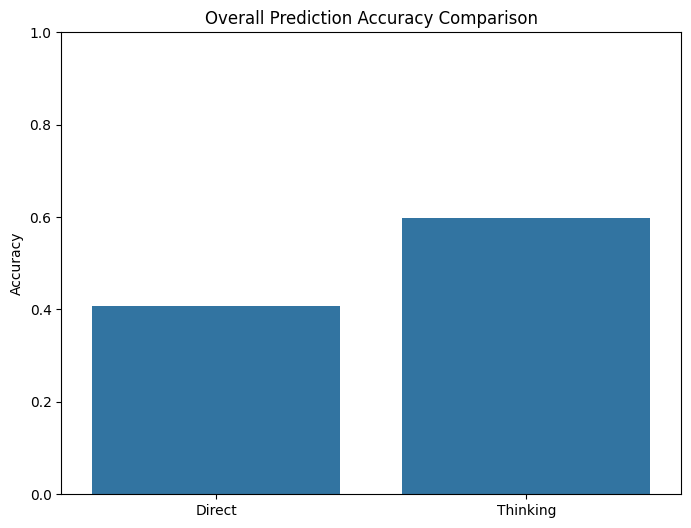

In [16]:
plt.figure(figsize=(8, 6))
sns.barplot(x=['Direct', 'Thinking'], y=[direct_accuracy, thinking_accuracy])
plt.title('Overall Prediction Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.savefig('figures/accuracy_comparison.png')
print("Saved overall accuracy comparison to Qwen3-VL/figures/accuracy_comparison.png")

In [17]:
direct_df_graph = direct_df.explode('problem_type_graph')
thinking_df_graph = thinking_df.explode('problem_type_graph')
direct_df_goal = direct_df.explode('problem_type_goal')
thinking_df_goal = thinking_df.explode('problem_type_goal')

Saved accuracy by graph type to Qwen3-VL/figures/accuracy_by_graph_type.png


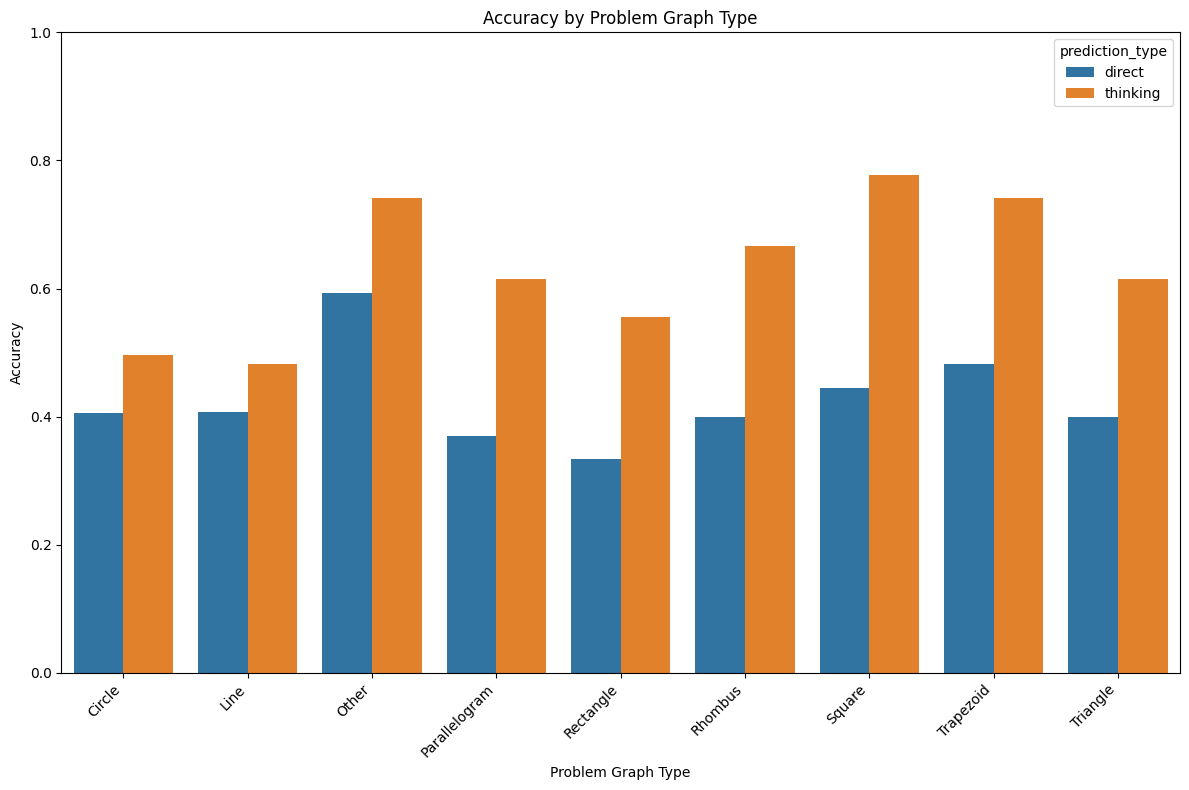

In [18]:
graph_accuracy_direct = direct_df_graph.groupby('problem_type_graph')['is_correct'].mean().reset_index()
graph_accuracy_thinking = thinking_df_graph.groupby('problem_type_graph')['is_correct'].mean().reset_index()

graph_accuracy = pd.merge(graph_accuracy_direct, graph_accuracy_thinking, on='problem_type_graph', suffixes=('_direct', '_thinking'))
graph_accuracy = pd.melt(graph_accuracy, id_vars='problem_type_graph', value_vars=['is_correct_direct', 'is_correct_thinking'], var_name='prediction_type', value_name='accuracy')
graph_accuracy['prediction_type'] = graph_accuracy['prediction_type'].str.replace('is_correct_', '')

plt.figure(figsize=(12, 8))
sns.barplot(data=graph_accuracy, x='problem_type_graph', y='accuracy', hue='prediction_type')
plt.title('Accuracy by Problem Graph Type')
plt.ylabel('Accuracy')
plt.xlabel('Problem Graph Type')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('figures/accuracy_by_graph_type.png')
print("Saved accuracy by graph type to Qwen3-VL/figures/accuracy_by_graph_type.png")

Saved accuracy by goal type to Qwen3-VL/figures/accuracy_by_goal_type.png


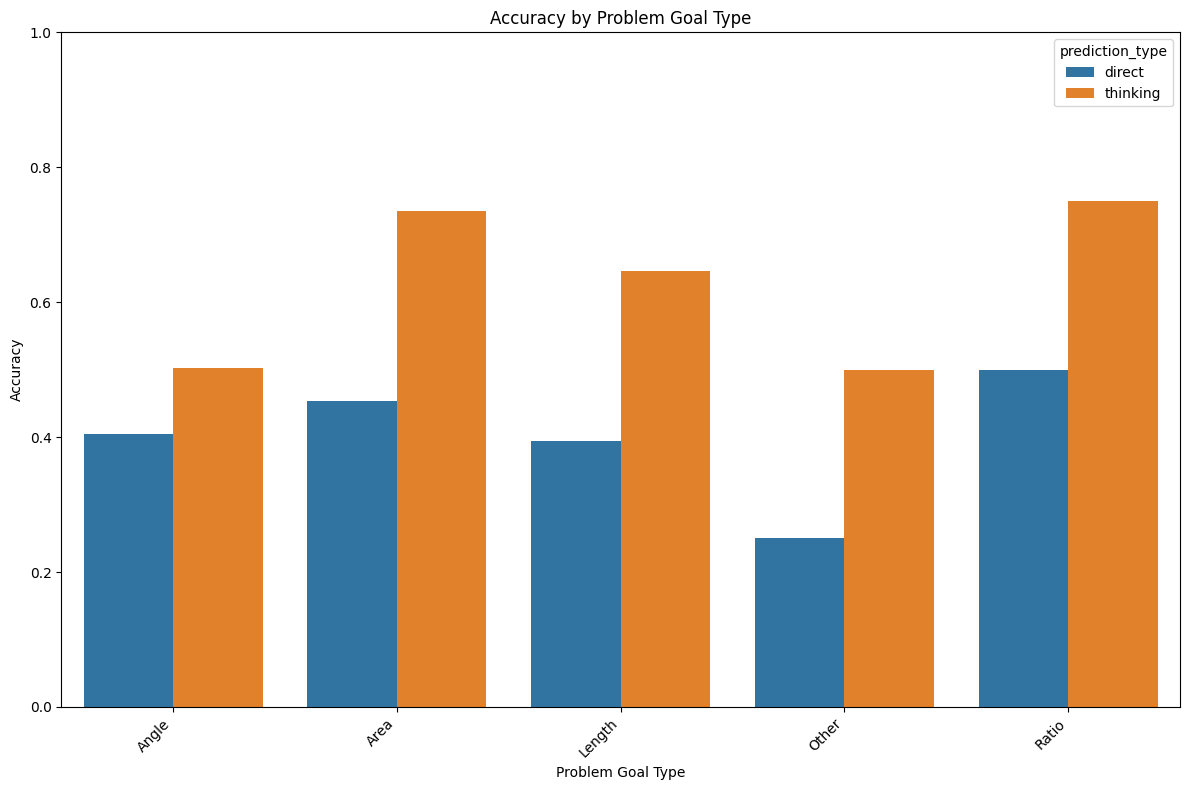

In [19]:
goal_accuracy_direct = direct_df_goal.groupby('problem_type_goal')['is_correct'].mean().reset_index()
goal_accuracy_thinking = thinking_df_goal.groupby('problem_type_goal')['is_correct'].mean().reset_index()

goal_accuracy = pd.merge(goal_accuracy_direct, goal_accuracy_thinking, on='problem_type_goal', suffixes=('_direct', '_thinking'))
goal_accuracy = pd.melt(goal_accuracy, id_vars='problem_type_goal', value_vars=['is_correct_direct', 'is_correct_thinking'], var_name='prediction_type', value_name='accuracy')
goal_accuracy['prediction_type'] = goal_accuracy['prediction_type'].str.replace('is_correct_', '')


plt.figure(figsize=(12, 8))
sns.barplot(data=goal_accuracy, x='problem_type_goal', y='accuracy', hue='prediction_type')
plt.title('Accuracy by Problem Goal Type')
plt.ylabel('Accuracy')
plt.xlabel('Problem Goal Type')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('figures/accuracy_by_goal_type.png')
print("Saved accuracy by goal type to Qwen3-VL/figures/accuracy_by_goal_type.png")